In [1]:
import scipy
import random
import portpy.photon as pp
import numpy as np
from cvxpy import *
from scipy import sparse
import sklearn.metrics
import cProfile
import time
import sys
import psutil
from sklearn.decomposition import PCA
import cvxpy as cp
import matplotlib.pyplot as plt

In [2]:
data_dir = r'../Data'
data = pp.DataExplorer(data_dir=data_dir)
patient_id = 'Lung_Phantom_Patient_1'
data.patient_id = patient_id
ct = pp.CT(data)
structs = pp.Structures(data)
beams = pp.Beams(data)
opt_params = data.load_config_opt_params(protocol_name='Lung_2Gy_30Fx')
structs.create_opt_structures(opt_params)
inf_matrix_sparse = pp.InfluenceMatrix(ct=ct, structs=structs, beams=beams)
protocol_name = 'Lung_2Gy_30Fx'
clinical_criteria = pp.ClinicalCriteria(data, protocol_name)
plan_sparse = pp.Plan(ct, structs, beams, inf_matrix_sparse, clinical_criteria)
opt = pp.Optimization(plan_sparse, opt_params=opt_params)

opt.create_cvxpy_problem()
time_sprs = time.time()
sol_sparse = opt.solve(solver='MOSEK', verbose=True)
print(time.time()- time_sprs)
dose_sparse_1d = plan_sparse.inf_matrix.A @ (sol_sparse['optimal_intensity'] * plan_sparse.get_num_of_fractions())
x_sparse =sol_sparse['optimal_intensity'] * plan_sparse.get_num_of_fractions()
beams_full = pp.Beams(data, load_inf_matrix_full=True)
inf_matrix_full = pp.InfluenceMatrix(ct=ct, structs=structs, beams=beams_full, is_full=True)
plan_full = pp.Plan(ct, structs, beams_full, inf_matrix_full, clinical_criteria)
dose_full_1d = plan_full.inf_matrix.A @ (sol_sparse['optimal_intensity'] * plan_full.get_num_of_fractions())
A_full = plan_full.inf_matrix.A
# A_full_csr = sparse.csr_matrix(A_full)
A_sparse = plan_sparse.inf_matrix.A
sparse_tol = plan_sparse.inf_matrix.sparse_tol
#print(sol_sparse['problem_value'])

creating rinds.. This step may take some time due to dilation
rinds created!!
Creating BEV..
Loading sparse influence matrix...
Done
Objective Start
Objective done
Constraints Start
Structure ESOPHAGUS not available!
Structure ESOPHAGUS not available!
Constraints done
                                     CVXPY                                     
                                     v1.4.1                                    
(CVXPY) Jan 28 02:43:26 PM: Your problem has 1946 variables, 14 constraints, and 0 parameters.
(CVXPY) Jan 28 02:43:26 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 28 02:43:26 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 28 02:43:26 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 28 02:43:26 PM: Your problem is compiled with the CPP canonicalization backend.
----------------------------------------

(CVXPY) Jan 28 02:43:29 PM:   Primal.  obj: 4.2045390107e+01    nrm: 1e+02    Viol.  con: 1e-06    var: 5e-07    cones: 0e+00  
(CVXPY) Jan 28 02:43:29 PM:   Dual.    obj: 4.2045390142e+01    nrm: 6e+03    Viol.  con: 0e+00    var: 9e-09    cones: 0e+00  
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Jan 28 02:43:29 PM: Problem status: optimal
(CVXPY) Jan 28 02:43:29 PM: Optimal value: 4.205e+01
(CVXPY) Jan 28 02:43:29 PM: Compilation took 1.344e+00 seconds
(CVXPY) Jan 28 02:43:29 PM: Solver (including time spent in interface) took 1.813e+00 seconds
3.213705062866211
Creating BEV..
Loading full influence matrix..
Done


In [3]:
A_full = plan_full.inf_matrix.A
A_sparse = plan_sparse.inf_matrix.A


sparse_tol = plan_sparse.inf_matrix.sparse_tol

A_full[A_full <= sparse_tol] = 0
test = np.abs(A_full - A_sparse.todense()) <= 1e-3

assert test.all()


In [4]:
S = A_sparse.transpose()
A = A_full
d = dose_full_1d
print(f'S = {S.shape}\nA = {A.shape}\nd = {d.shape}')

sol_ls_A_sparse = scipy.sparse.linalg.lsqr(S@A, S@d)


#sol_ls_A_full = scipy.sparse.linalg.lsqr(A_full, dose_full_1d)
#x_A_full_1 = sol_ls_A_full[0]


S = (542, 60183)
A = (60183, 542)
d = (60183,)


In [5]:
opt = pp.Optimization(plan_full, opt_params=opt_params)
opt.create_cvxpy_problem()

sol_full = opt.solve(solver='MOSEK', verbose=False)

x_full = sol_full['optimal_intensity'] * plan_full.get_num_of_fractions()

Objective Start
Objective done
Constraints Start
Structure ESOPHAGUS not available!
Structure ESOPHAGUS not available!
Constraints done


In [6]:
x_sparse_1 = sol_ls_A_sparse[0]

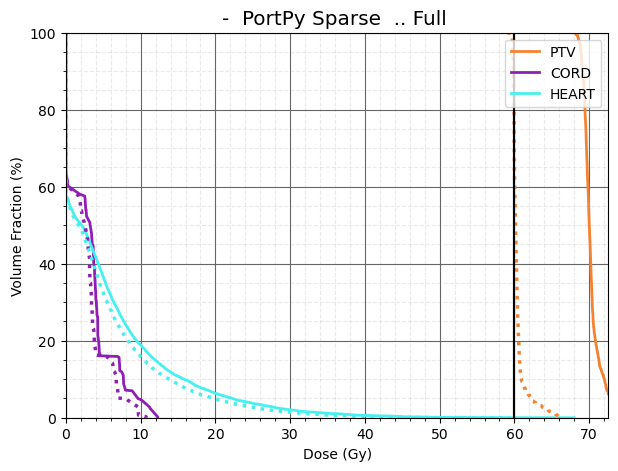

Done!


In [7]:
#x_sparse_1

dose_full = plan_full.inf_matrix.A @ x_full
dose_sparse = plan_full.inf_matrix.A @ x_sparse_1


fig, ax = plt.subplots(figsize=(7, 5))
struct_names = ['PTV', 'ESOPHAGUS', 'HEART', 'CORD']
ax = pp.Visualization.plot_dvh(plan_full, dose_1d=dose_sparse, struct_names=struct_names, style='solid', ax=ax)
ax = pp.Visualization.plot_dvh(plan_full, dose_1d=dose_full, struct_names=struct_names, style='dotted', ax=ax)
ax.set_title('-  PortPy Sparse  .. Full ')
plt.show()
print('Done!')

In [8]:
opt = pp.Optimization(plan_full, opt_params=opt_params)
opt.create_cvxpy_problem()

sol= opt.solve(solver='MOSEK', verbose=False)

Objective Start
Objective done
Constraints Start
Structure ESOPHAGUS not available!
Structure ESOPHAGUS not available!
Constraints done


In [9]:
# visualize plan metrics based upon clinical criteria
pp.Evaluation.display_clinical_criteria(plan_full, sol=sol)

,name,parameters,constraints,Plan Value
0,max_dose,{'structure_name': 'GTV'},"{'limit_dose_gy': 69, 'goal_dose_gy': 66}",65.960524
1,max_dose,{'structure_name': 'PTV'},"{'limit_dose_gy': 69, 'goal_dose_gy': 66}",65.960524
2,max_dose,{'structure_name': 'HEART'},{'limit_dose_gy': 66},59.355851
3,mean_dose,{'structure_name': 'HEART'},"{'limit_dose_gy': 27, 'goal_dose_gy': 20}",4.756937
4,dose_volume_V,"{'structure_name': 'HEART', 'dose_gy': 30}",{'limit_volume_perc': 50},1.433086
5,dose_volume_V,"{'structure_name': 'HEART', 'dose_gy': 30}",{'goal_volume_perc': 48},1.433086
6,max_dose,{'structure_name': 'LUNG_L'},{'limit_dose_gy': 66},65.960524
7,max_dose,{'structure_name': 'LUNG_R'},{'limit_dose_gy': 66},25.475049
8,max_dose,{'structure_name': 'CORD'},"{'limit_dose_gy': 50, 'goal_dose_gy': 48}",10.729718
9,max_dose,{'structure_name': 'SKIN'},{'limit_dose_gy': 60},50.964038


<Axes: xlabel='x-axis (beamlets column)', ylabel='y-axis (beamlets row)'>

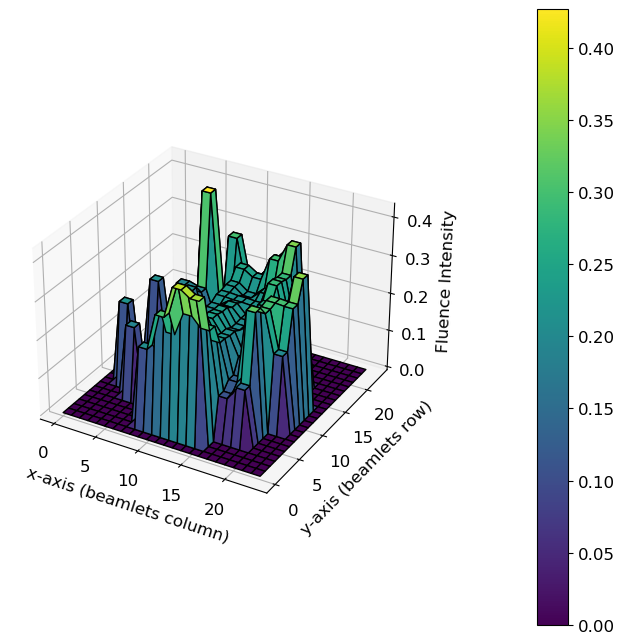

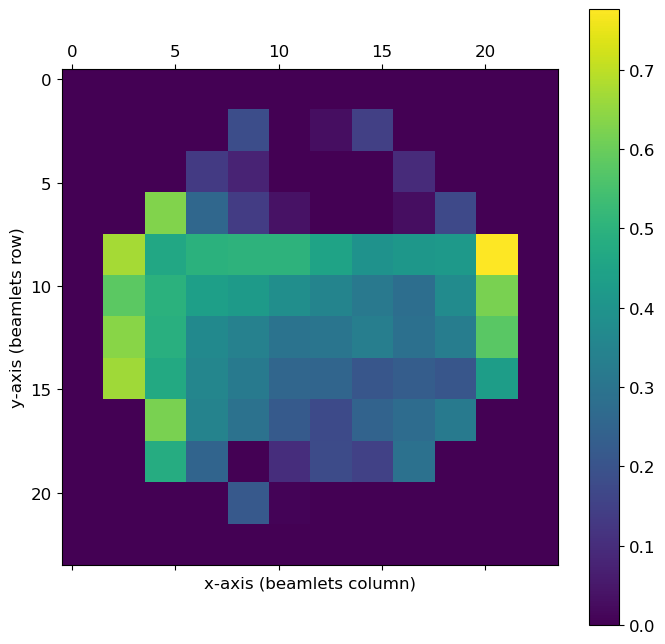

In [10]:
# plot fluence 3d and 2d for the 1st beam
pp.Visualization.plot_fluence_3d(sol=sol_sparse, beam_id=plan_sparse.beams.get_all_beam_ids()[1])

pp.Visualization.plot_fluence_2d(sol=sol_sparse, beam_id=plan_sparse.beams.get_all_beam_ids()[0])


<Axes: title={'center': 'Axial View - Slice #: 60'}>

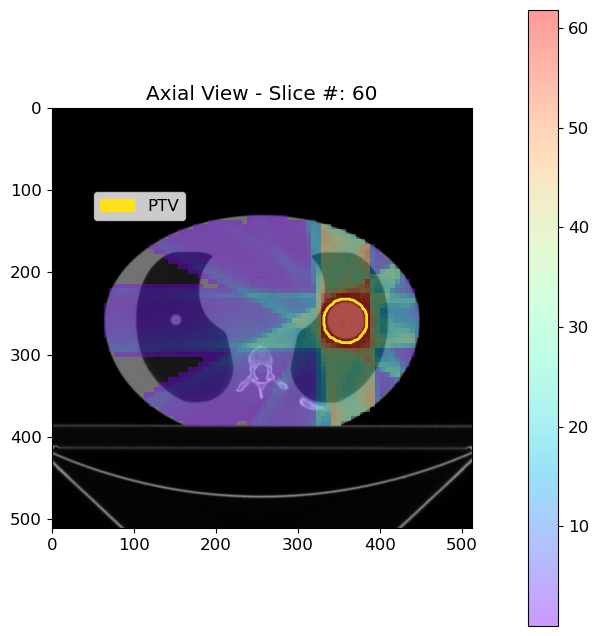

In [11]:
# plot 2d axial slice for the given solution and display the structures contours on the slice
pp.Visualization.plot_2d_slice(my_plan=plan_full, sol=sol_sparse, slice_num=60, struct_names=['PTV'])

In [12]:
# نوع داده
print("Data Type:", dose_sparse.dtype)

# ابعاد
print("Shape:", dose_sparse.shape)

# تعداد کل عناصر
print("Size:", dose_sparse.size)


Data Type: float64
Shape: (60183,)
Size: 60183


In [15]:
import pandas as pd

# ساخت یک DataFrame از یک numpy.ndarray
dose_sparse_df = pd.DataFrame(dose_sparse)

# استفاده از تابع describe بر روی DataFrame
description = dose_sparse_df.describe()

# نمایش توضیحات
print(description)


               0
count  60183.000
mean       5.978
std       12.423
min        0.000
25%        0.000
50%        0.031
75%        5.750
max       77.451
